In [1]:
from timbr import Snapshot
%reload_ext timbr.notebook
%timbr SnapshotSelector

<IPython.core.display.Javascript object>

In [4]:
data = Snapshot("/Users/chelm/.timbr/data/instagram_food")

In [5]:
from IPython.display import HTML

HTML('<h1>{} Rows</h1>'.format(len(data)))

In [6]:
from IPython.display import HTML

out = '<h1>Raw Data Keys</h1>'
for key in data[0][1].keys():
    out += '<span style="margin:20px; font-size:16px;">- {}</span></br>'.format(key)
    
HTML(out)

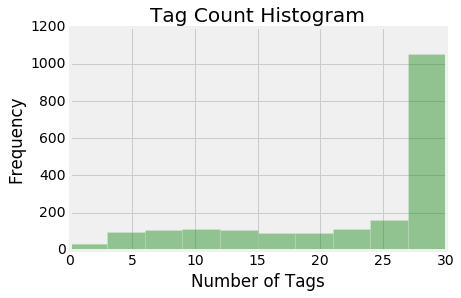

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

tag_counts = [len(row['tags']) for i, row in data]

plt.hist(tag_counts, color='g', alpha=0.4)
plt.style.use('fivethirtyeight')
plt.title("Tag Count Histogram")
plt.xlabel("Number of Tags")
plt.ylabel("Frequency")
plt.show()

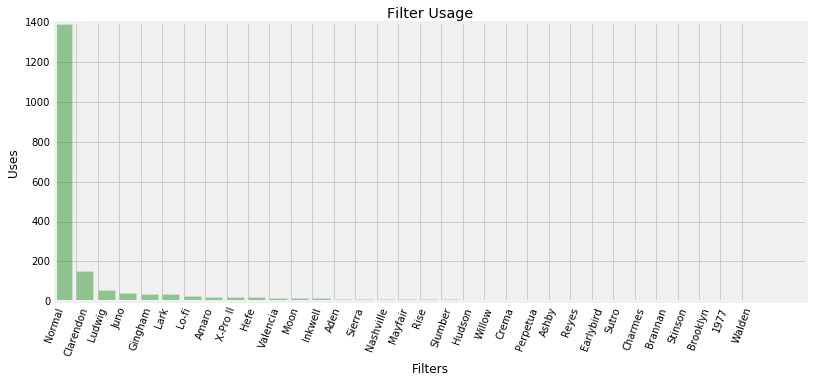

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
from operator import itemgetter

filters = sorted(Counter([str(row['filter']) for i, row in data]).items(), key=itemgetter(1), reverse=True)

fig, ax = plt.subplots()
ax.bar(range(len(filters)), [x[1] for x in filters], color='g', alpha=0.4)

plt.xticks(range(len(filters)), [x[0] for x in filters], rotation=45 )

plt.title("Filter Usage")
plt.ylabel('Uses')
plt.xlabel('Filters')
fig.set_size_inches(12, 5)
plt.xticks(rotation=70)
plt.show()

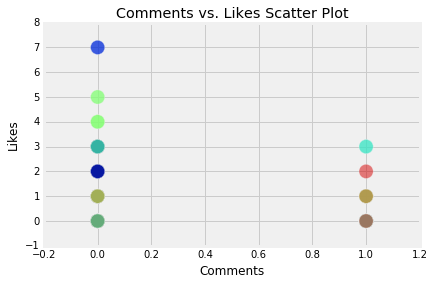

In [9]:
"""Plots a scatter plot comparing comments to likes in Instagram posts"""

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

def collect(l, index):
   return map(itemgetter(index), l)

social = [(row['comments']['count'], row['likes']['count'])  for i, row in data]

comments = collect(social, 0)
likes    = collect(social, 1)

N = len(social)

colors = np.random.rand( N )
area = [200]*N
plt.scatter(comments, likes, s=area, c=colors, alpha=0.5)
plt.title("Comments vs. Likes Scatter Plot")
plt.xlabel("Comments")
plt.ylabel("Likes")
plt.show()

In [16]:
"""Create a map of instagram posts """
import folium, json
from IPython.core.display import HTML

def create_map(data, width=950, height=500):
    tileset = r'http://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}.png'
    m = folium.Map(location=[38, 0], zoom_start=2, tiles=tileset, attr='Esri Tiles')
    for i, row in data:
        if row['location'] is not None:
            m.circle_marker(location=[row['location']['latitude'], row['location']['longitude']], radius=500, 
              popup='<img width=150 height=150 src="'+row['images']['low_resolution']['url']+'"/>', line_color='hotpink',
              fill_color='#3186cc', fill_opacity=1)
    
    m._build_map()
    srcdoc = m.HTML.replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{}" '
                 'style="width: {}px; height: {}px; '
                 'border: none"></iframe>'.format(srcdoc, width, height))
    return embed

create_map(data)

In [18]:
%matplotlib inline
import networkx as nx
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt
from string import Template
import json, time
from IPython.display import HTML
from IPython.core.display import display_html, display_javascript, Javascript

def graphData(s1, s2):
    G = nx.Graph()  
    for i in xrange(len(s1)):
        filt = s1[i]
        name = s2[i]
        G.add_edge(name, filt) 
    return json_graph.node_link_data(G)

filters = [str(x['filter']) for i, x in data]
usernames = [str(x['user']['username']) for i, x in data]

graph_data = graphData(filters, usernames)

for i in xrange(len(graph_data['nodes'])):
    id = graph_data['nodes'][i]['id'] 
    if id in usernames:
        index = usernames.index(id)
        graph_data['nodes'][i]['type'] = filters[index]

html = """<h2>Network of Users and Filters</h2><div id="chart"></div>"""
d3js = Template("""
var width = 500,
  height = 400;

var force = d3.layout.force()
  .charge(-150)
  .gravity(5)
  .linkDistance(1)
  .size([500, 400]);

var svg = d3.select("#chart").append("svg")
  .attr("width", width)
  .attr("height", height);
  
var graph = $graph;
graph.nodes = JSON.parse(graph.nodes);
graph.links = JSON.parse(graph.links);
var colors = d3.scale.category20()

force
  .nodes(graph.nodes)
  .links(graph.links)
  .start();

var link = svg.selectAll(".link")
    .data(graph.links)
  .enter().append("line")
    .attr("class", "link")
    .style("stroke", "#999")
    .style("stroke-width", function(d) { return Math.sqrt(d.value); });

var node = svg.selectAll(".node")
    .data(graph.nodes)
  .enter().append("circle")
    .attr("class", function(d) { return "node " + d.type} )
    .attr("r", 3)
    .style("fill", function(d) { return (d.type) ? colors(d.type) : colors(d.id); })
    .on("click", function(d) { console.log(d); })
    .call(force.drag);

node.append("title")
    .text(function(d) { return d.name; });

force.on("tick", function() {
  link.attr("x1", function(d) { return d.source.x; })
    .attr("y1", function(d) { return d.source.y; })
    .attr("x2", function(d) { return d.target.x; })
    .attr("y2", function(d) { return d.target.y; });

  node.attr("cx", function(d) { return d.x; })
    .attr("cy", function(d) { return d.y; });
});
     
""")

js_libs = ['https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.6/d3.min.js']
display_javascript( Javascript(data='', lib=js_libs))

time.sleep(1)

def renderd3(html, js, libs=[]):   
    display_html(HTML(data=html))
    display_javascript( Javascript(data=js, lib=libs))  
    
d3js = d3js.substitute({"graph": {
        "nodes": str(json.dumps(graph_data['nodes'])),
        "links": str(json.dumps(graph_data['links']))}})

renderd3(html, d3js)
